In [302]:
!pip install pandas
!pip install opencv-python
!pip install matplotlib
!pip install tqdm

  Using cached tqdm-4.62.0-py2.py3-none-any.whl (76 kB)


In [ ]:
!git clone https://github.com/twitter-research/image-crop-analysis

### Download Twitter Emoji

In [8]:
!wget https://emojipedia.org/twitter/twemoji-13.1/ -O twemoji.html 2&> /dev/null

In [10]:
import re

with open("twemoji.html", "r") as fin:
    twemoji_html = "".join(fin.readlines())
    links = re.findall('https://[^/]*/[^/]*/72/[^/]*/[^/]*/[^/.]*\.png', twemoji_html)
    with open("twemoji_links.txt", "w") as fout:
        fout.write("\n".join(links))

In [27]:
![[ ! -e twemoji ]] && mkdir twemoji
!cat twemoji_links.txt | parallel 'wget -P twemoji' 2&> /dev/null

### Skin-tone Emoji

In [69]:
import glob
import cv2

import matplotlib.pyplot as plt
import pandas as pd

In [127]:
emoji_df = pd.DataFrame().from_records(
    map(lambda t: (t,), glob.glob("twemoji/*.png")), 
    columns = ['emoji']
)
emoji_df.head(5)

,emoji
0,twemoji/grinning-face-with-big-eyes_1f603.png
1,twemoji/grinning-squinting-face_1f606.png
2,twemoji/face-savoring-food_1f60b.png
3,twemoji/grinning-face-with-smiling-eyes_1f604.png
4,twemoji/kissing-face-with-closed-eyes_1f61a.png


In [128]:
def skintone_from_path(path):
    skintone_re_groups = re.findall('((dark-|light-|medium-)+skin-tone)', path)
    skintone = tuple(map(lambda cg: cg[0], skintone_re_groups))
    return skintone

emoji_df['skin-tone'] = emoji_df.emoji.apply(skintone_from_path)
emoji_df['skin-tone'].value_counts()

()                                                 1845
(medium-skin-tone,)                                 296
(light-skin-tone,)                                  296
(medium-light-skin-tone,)                           296
(medium-dark-skin-tone,)                            296
(dark-skin-tone,)                                   296
(medium-light-skin-tone, light-skin-tone)            12
(medium-dark-skin-tone, medium-skin-tone)            12
(dark-skin-tone, medium-dark-skin-tone)              12
(light-skin-tone, medium-skin-tone)                  12
(light-skin-tone, medium-dark-skin-tone)             12
(medium-light-skin-tone, dark-skin-tone)             12
(dark-skin-tone, light-skin-tone)                    12
(medium-light-skin-tone, medium-skin-tone)           12
(medium-skin-tone, light-skin-tone)                  12
(light-skin-tone, dark-skin-tone)                    12
(medium-dark-skin-tone, medium-light-skin-tone)      12
(medium-dark-skin-tone, dark-skin-tone)         

In [129]:
# we focus only on emoji with a single skin-tone 

In [130]:
emoji_with_skin_tone_df = emoji_df[
    emoji_df['skin-tone'].apply(len) == 1
].reset_index(drop = True)

len( emoji_with_skin_tone_df['skin-tone'] )

1480

In [131]:
emoji_with_skin_tone_df.emoji

0       twemoji/waving-hand_light-skin-tone_1f44b-1f3f...
1       twemoji/raised-back-of-hand_medium-dark-skin-t...
2       twemoji/raised-back-of-hand_medium-skin-tone_1...
3       twemoji/hand-with-fingers-splayed_light-skin-t...
4       twemoji/raised-back-of-hand_dark-skin-tone_1f9...
                              ...                        
1475    twemoji/man-in-suit-levitating-medium-skin-ton...
1476    twemoji/woman-in-suit-levitating-dark-skin-ton...
1477    twemoji/woman-in-suit-levitating-medium-dark-s...
1478    twemoji/man-in-suit-levitating-light-skin-tone...
1479    twemoji/man-in-suit-levitating-medium-dark-ski...
Name: emoji, Length: 1480, dtype: object

In [133]:
an_emoji_set = emoji_with_skin_tone_df[ emoji_with_skin_tone_df.emoji.str.contains('waving-hand_') ].reset_index(drop = True)
an_emoji_set

,emoji,skin-tone
0,twemoji/waving-hand_light-skin-tone_1f44b-1f3f...,"(light-skin-tone,)"
1,twemoji/waving-hand_medium-light-skin-tone_1f4...,"(medium-light-skin-tone,)"
2,twemoji/waving-hand_medium-dark-skin-tone_1f44...,"(medium-dark-skin-tone,)"
3,twemoji/waving-hand_dark-skin-tone_1f44b-1f3ff...,"(dark-skin-tone,)"
4,twemoji/waving-hand_medium-skin-tone_1f44b-1f3...,"(medium-skin-tone,)"


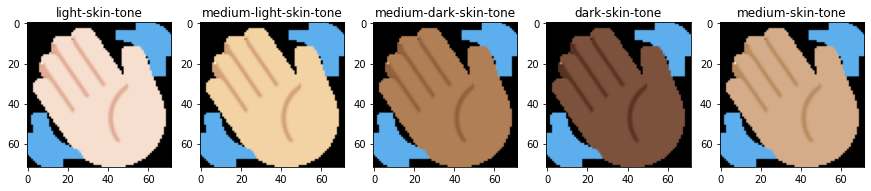

In [147]:
fig, axes = plt.subplots(ncols = len(an_emoji_set), figsize = (15, 5))

for i, row in an_emoji_set.iterrows():
    an_emoji_img = cv2.imread(row.emoji, flags = cv2.IMREAD_UNCHANGED) 
    an_emoji_img = cv2.cvtColor(an_emoji_img, cv2.COLOR_BGRA2RGB)

    axes[i].set_title(row['skin-tone'][0])
    axes[i].imshow(an_emoji_img)

### Saliency on Twitter Emoji

In [208]:
import numpy as np

In [215]:
emoji_l = emoji_with_skin_tone_df.sample(1, random_state = 1337).iloc[0]
emoji_r = emoji_with_skin_tone_df.sample(1, random_state = 42).iloc[0]

In [298]:
def collage(emoji_l, emoji_r, background):
    emoji_l_img = cv2.imread(emoji_l, flags = cv2.IMREAD_UNCHANGED)
    emoji_l_img_mask = emoji_l_img[:, :, 3] == 0
    emoji_l_img = cv2.cvtColor(emoji_l_img, cv2.COLOR_BGRA2RGB)
    
    emoji_r_img = cv2.imread(emoji_r, flags = cv2.IMREAD_UNCHANGED)
    emoji_r_img_mask = emoji_r_img[:, :, 3] == 0
    emoji_r_img = cv2.cvtColor(emoji_r_img, cv2.COLOR_BGRA2RGB)
    
    if background == 'black':
        space = np.zeros_like(emoji_l_img)
    elif background == 'white':
        emoji_l_img[emoji_l_img_mask] = 255
        emoji_r_img[emoji_r_img_mask] = 255
        space = np.ones_like(emoji_l_img) * 255
    else:
        raise Exception()
        
    return np.concatenate([emoji_l_img, space, emoji_r_img])

In [299]:
black_collage = collage(emoji_l.emoji, emoji_r.emoji, 'black')
white_collage = collage(emoji_l.emoji, emoji_r.emoji, 'white')

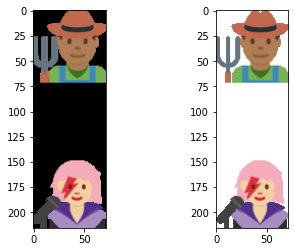

In [300]:
_, axes = plt.subplots(ncols = 2)

axes[0].imshow(black_collage)
axes[1].imshow(white_collage)

In [220]:
import sys
sys.path.append("./image-crop-analysis/src/")
import platform

from pathlib import Path
from crop_api import ImageSaliencyModel

In [221]:
BIN_MAPS = {"Darwin": "mac", "Linux": "linux"}
HOME_DIR = Path("image-crop-analysis").expanduser()

In [222]:
bin_dir = HOME_DIR / Path("./bin")
bin_path = bin_dir / BIN_MAPS[platform.system()] / "candidate_crops"
model_path = bin_dir / "fastgaze.vxm"

In [223]:
def _tmp_im(img):
    """
    write image to a dummy jpeg file, returns its path.
    The path is always the same.
    """
    tmp_path = Path('/tmp/dummy.jpeg')
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(str(tmp_path), img)
    return tmp_path 

model = ImageSaliencyModel(crop_binary_path=bin_path, crop_model_path=model_path)

None 72 216


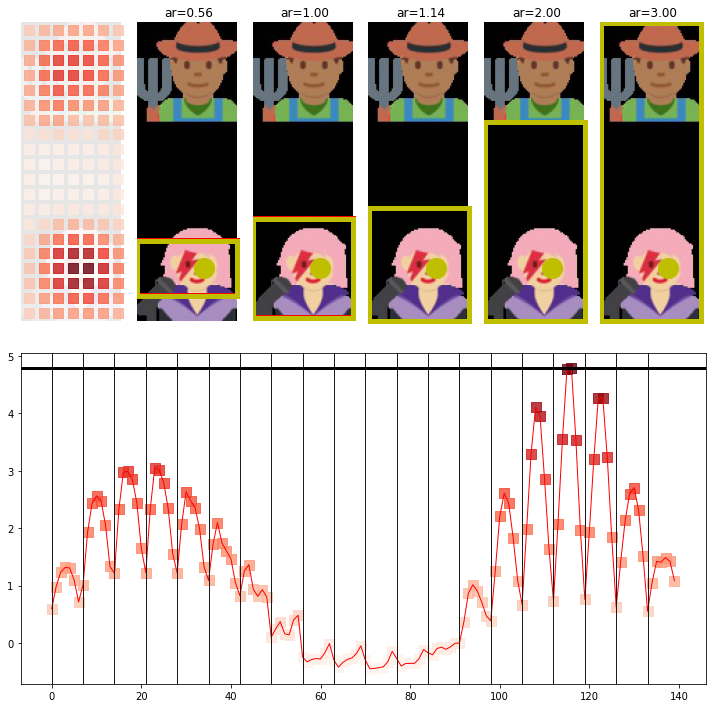

In [224]:
model.plot_img_crops(_tmp_im(black_collage))

None 72 216


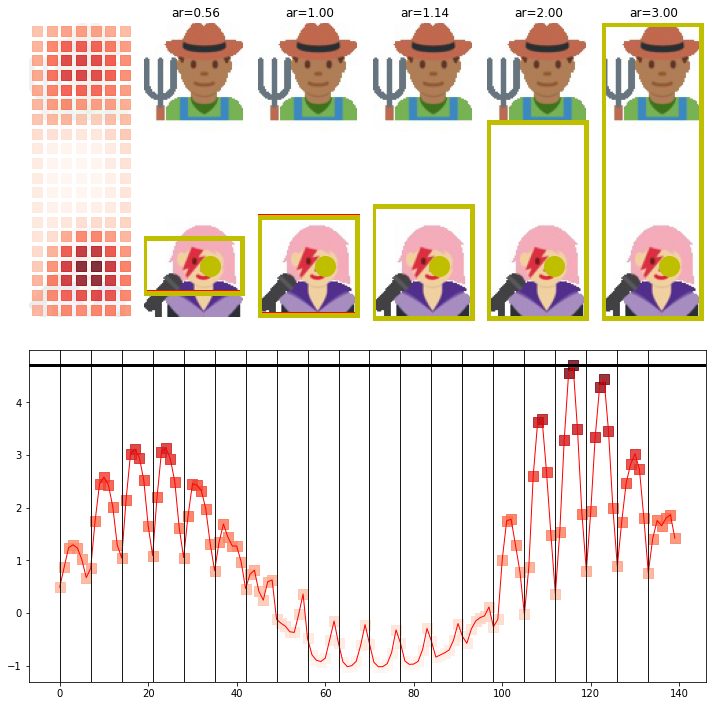

In [225]:
model.plot_img_crops(_tmp_im(white_collage))

### Group Experiment

In [231]:
import itertools

In [232]:
skin_tones = emoji_with_skin_tone_df['skin-tone'].unique()
skin_tones

array([('light-skin-tone',), ('medium-dark-skin-tone',),
       ('medium-skin-tone',), ('dark-skin-tone',),
       ('medium-light-skin-tone',)], dtype=object)

In [233]:
pair_combinations = list(itertools.combinations(skin_tones, 2))

In [285]:
np.random.seed(1337)
experiment_df = pd.DataFrame(columns = ['st1', 'st2', 'emoji1', 'emoji2', 'background'])

N = 5000
for st1, st2 in pair_combinations:
    # Sample N random emoji for each skin-tone. Sampling is with repetition, creating
    # >1 examples for each emoji.
    st1_selected = emoji_with_skin_tone_df[emoji_with_skin_tone_df['skin-tone'] == st1].emoji.sample(N, replace = True)
    st2_selected = emoji_with_skin_tone_df[emoji_with_skin_tone_df['skin-tone'] == st2].emoji.sample(N, replace = True)
    
    # Adding skin-tone information to the pair.
    st1_selected = list(zip([st1]*len(st1_selected), st1_selected))
    st2_selected = list(zip([st2]*len(st2_selected), st2_selected))
    
    # Create N randoms pairs mergint the two selections.
    # Each pair is shuffled (i.e: st1/st2 can be to the left or right randomly)
    skin_tones_pairs = [
        sorted(pair, key = lambda x: np.random.random() - 0.5) 
        for pair in list(zip(st1_selected, st2_selected))
    ]
    
    # White or Black backgruound set randomly
    background = np.random.choice(['white', 'black'], size = N, replace = True)
    # Create the dataset
    left, right = zip(*skin_tones_pairs)
    left_skin_tone, left_emoji = zip(*left)
    right_skin_tone, right_emoji = zip(*right)
    
    experiment_df = experiment_df.append(
        pd.DataFrame().from_records(zip(left_skin_tone, right_skin_tone, left_emoji, right_emoji, background), columns = experiment_df.columns),
        ignore_index = True
    )

In [307]:
experiment_df = experiment_df.reset_index(drop = True)
experiment_df.head()

,st1,st2,emoji1,emoji2,background
0,"(light-skin-tone,)","(medium-dark-skin-tone,)",twemoji/guard_light-skin-tone_1f482-1f3fb_1f3f...,twemoji/man-rowing-boat-medium-dark-skin-tone_...,white
1,"(light-skin-tone,)","(medium-dark-skin-tone,)",twemoji/fairy_light-skin-tone_1f9da-1f3fb_1f3f...,twemoji/person-kneeling_medium-dark-skin-tone_...,black
2,"(light-skin-tone,)","(medium-dark-skin-tone,)",twemoji/person-in-steamy-room_light-skin-tone_...,twemoji/man-health-worker-medium-dark-skin-ton...,white
3,"(light-skin-tone,)","(medium-dark-skin-tone,)",twemoji/woman-in-tuxedo-light-skin-tone_1f935-...,twemoji/man-artist-medium-dark-skin-tone_1f468...,white
4,"(medium-dark-skin-tone,)","(light-skin-tone,)",twemoji/man-running-medium-dark-skin-tone_1f3c...,twemoji/woman-in-tuxedo-light-skin-tone_1f935-...,black


In [308]:
len(experiment_df)

50000

In [371]:
# duplicated entries
experiment_df.duplicated().astype(int).sum()

364

In [375]:
experiment_df = experiment_df[~experiment_df.duplicated()]
len(experiment_df)

49636

In [376]:
# Pair of skin-tones appears equally
experiment_df.groupby(['st1', 'st2', 'background']).count()

emoji1  emoji2
st1                       st2                       background                
(dark-skin-tone,)         (light-skin-tone,)        black         1299    1299
                                                    white         1188    1188
                          (medium-dark-skin-tone,)  black         1166    1166
                                                    white         1313    1313
                          (medium-light-skin-tone,) black         1253    1253
                                                    white         1207    1207
                          (medium-skin-tone,)       black         1255    1255
                                                    white         1218    1218
(light-skin-tone,)        (dark-skin-tone,)         black         1241    1241
                                                    white         1239    1239
                          (medium-dark-skin-tone,)  black         1280    1280
                                                    white         1270    1270
                          (medium-light-skin-tone,) black         1177    1177
                                                    white         1273    1273
                          (medium-skin-tone,)       black         1223    1223
                                                    white         1265    1265
(medium-dark-skin-tone,)  (dark-skin-tone,)         black         1196    1196
                                                    white         1293    1293
                          (light-skin-tone,)        black         1216    1216
                                                    white         1200    1200
                          (medium-light-skin-tone,) black         1204    1204
                                                    white         1331    1331
                          (medium-skin-tone,)       black         1249    1249
                                                    white         1265    1265
(medium-light-skin-tone,) (dark-skin-tone,)         black         1281    1281
                                                    white         1209    1209
                          (light-skin-tone,)        black         1242    1242
                                                    white         1261    1261
                          (medium-dark-skin-tone,)  black         1223    1223
                                                    white         1206    1206
                          (medium-skin-tone,)       black         1265    1265
                                                    white         1249    1249
(medium-skin-tone,)       (dark-skin-tone,)         black         1254    1254
                                                    white         1250    1250
                          (light-skin-tone,)        black         1266    1266
                                                    white         1215    1215
                          (medium-dark-skin-tone,)  black         1221    1221
                                                    white         1229    1229
                          (medium-light-skin-tone,) black         1231    1231
                                                    white         1213    1213

In [377]:
experiment_df.to_csv("twitter_emoji_pairs_experiment.csv", index = False)

### Saliency Extraction

In [311]:
!mkdir twitter_emoji_collage

mkdir: cannot create directory ‘twitter_emoji_collage’: File exists


In [312]:
import tqdm

for i, row in tqdm.tqdm( experiment_df.iterrows(), total = len(experiment_df)):
    collage_img = collage(row.emoji1, row.emoji2, row.background)
    collage_img = cv2.cvtColor(collage_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(f"twitter_emoji_collage/{i}.jpeg", collage_img)

100%|██████████| 50000/50000 [01:11<00:00, 695.62it/s]


In [317]:
!ls twitter_emoji_collage | wc -l

50000


In [323]:
%%html
<img src="./twitter_emoji_collage/3.jpeg" >

In [363]:
%%bash
cat <<EOF > fastgaze_for_parallel.sh
#!/bin/sh
./image-crop-analysis/bin/linux/candidate_crops ./image-crop-analysis/bin/fastgaze.vxm $(pwd)/\$1 show_all_points > $(pwd)/\$1.txt
EOF
chmod +x fastgaze_for_parallel.sh

In [366]:
!ls twitter_emoji_collage/**.jpeg | parallel -j 30 './fastgaze_for_parallel.sh'

Academic tradition requires you to cite works you base your article on.
When using programs that use GNU Parallel to process data for publication
please cite:

  O. Tange (2011): GNU Parallel - The Command-Line Power Tool,
  ;login: The USENIX Magazine, February 2011:42-47.

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

To silence the citation notice: run 'parallel --bibtex'.

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show_all_points
showAllPoints=true, argv[3]=show

In [456]:
results = []
for i, rows in tqdm.tqdm( experiment_df.iterrows(), total = len(experiment_df) ):
    fastgaze_output = parse_output("".join(open(f"twitter_emoji_collage/{i}.jpeg.txt").readlines()))
    
    if fastgaze_output['salient_point'][0][1] <= 72:
        # saliency on emoji1
        results.append(rows.st1)
    elif fastgaze_output['salient_point'][0][1] >= 2*72:
        # saliency on emoji2
        results.append(rows.st2)
    else:
        # should be impossible
        assert (False)

100%|██████████| 49636/49636 [00:32<00:00, 1525.78it/s]


In [458]:
experiment_df['saliency'] = results

In [465]:
experiment_df.to_csv("experiment_results.csv", index = False)

## Results

In [548]:
CI = 0.95
BAR_WIDTH = 0.4
SORTED_SKIN_TONES = [
    'light-skin-tone', 
    'medium-light-skin-tone', 
    'medium-skin-tone', 
    'medium-dark-skin-tone',
    'dark-skin-tone'
]

def short_st(st):
    if st == 'light-skin-tone':
        return "L"
    elif st == 'medium-light-skin-tone':
        return "ML"
    elif st == 'medium-skin-tone':
        return "M"
    elif st == 'medium-dark-skin-tone':
        return "MD"
    elif st == 'dark-skin-tone':
            return "D"
    raise Exception()

In [540]:
experiment_df.head(1)

,st1,st2,emoji1,emoji2,background,saliency
0,"(light-skin-tone,)","(medium-dark-skin-tone,)",twemoji/guard_light-skin-tone_1f482-1f3fb_1f3f...,twemoji/man-rowing-boat-medium-dark-skin-tone_...,white,"(light-skin-tone,)"


In [541]:
# single skin-tone
results_single = {}

for skin_tone in experiment_df.st1.unique():
    pairs_with_skin_tone = experiment_df[((experiment_df.st1 == skin_tone) | (experiment_df.st2 == skin_tone))]
    won = (pairs_with_skin_tone.saliency == skin_tone).astype(int).sum()
    
    results_single[frozenset(skin_tone)] = (won, len(pairs_with_skin_tone))
    
# pairs skin-tone
results_pairs = {}

for skin_tone_a, skin_tone_b in itertools.combinations(experiment_df.st1.unique(), 2):
    
    pairs_with_skin_tone = experiment_df[(
        ((experiment_df.st1 == skin_tone_a) | (experiment_df.st1 == skin_tone_b)) &
        ((experiment_df.st2 == skin_tone_a) | (experiment_df.st2 == skin_tone_b))
    )]
    
    won_a = pairs_with_skin_tone.saliency.value_counts()[skin_tone_a]
    won_b = pairs_with_skin_tone.saliency.value_counts()[skin_tone_b]
    
    results_pairs[frozenset(skin_tone_a + skin_tone_b)] = (won_a, won_b)

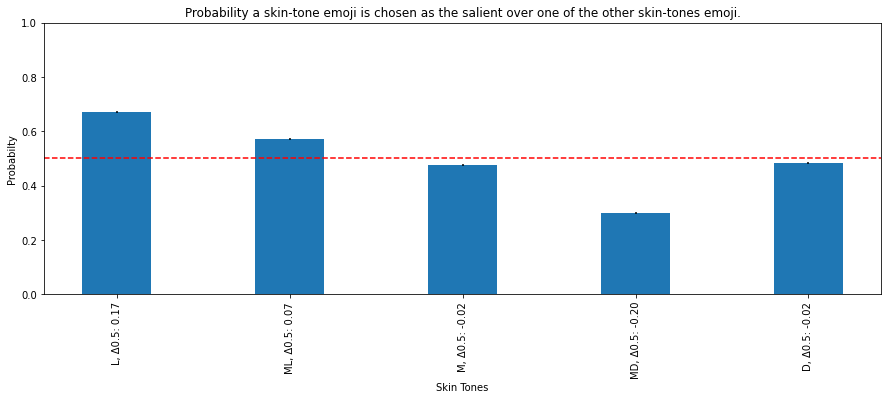

In [557]:
# single chart

y = []
x = []
y_err = []

for group in SORTED_SKIN_TONES:
    group = frozenset((group,))
    support = results_single[group][1] 
    won_over_other_p = results_single[group][0] / support
 
    y_err.append( CI * np.sqrt( (won_over_other_p * (1-won_over_other_p)) / support) )
    y.append(won_over_other_p)
    x.append(f"{short_st(tuple(group)[0])}, Δ0.5: {won_over_other_p-0.5:.2f}")

plt.figure(figsize = (15, 5))

plt.bar(np.arange(len(x)), y, BAR_WIDTH, yerr = y_err)
plt.axhline(0.5, c = 'red', linestyle = 'dashed')

plt.title("Probability a skin-tone emoji is chosen as the salient over one of the other skin-tones emoji.")
plt.xlabel("Skin Tones")
plt.ylabel("Probabilty")
plt.ylim(0, 1)
plt.xticks(np.arange(len(x)), x, rotation = 90)
plt.show()

* Light Skin Tone has more chance (+$17\%$) being considered salient over all the other skin-tones.
* Medium Dark Skin Tone is the least preferred by the cropping algorithm ($-20\%$).
* Generally the darker the skin tone, the less likely is that an emoji is preferred, with the exception of the darkest group ("dark-skin-tone").

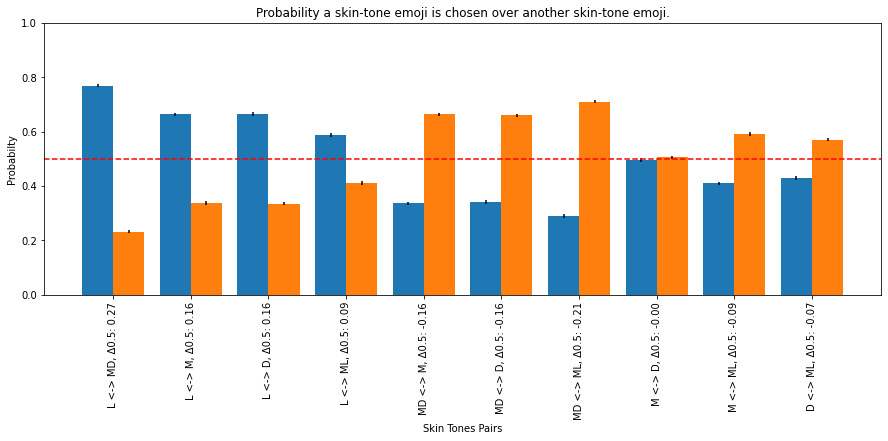

In [559]:
st1_y, st2_y = [], []
st1_y_err, st2_y_err = [], []
x = []

for st1, st2 in pair_combinations:
    r = results_pairs[frozenset(st1+st2)]
    
    support = sum(r)
    st1_won_over_st2 = r[0] / support
    st2_won_over_st1 = r[1] / support
    
    st1_y.append(st1_won_over_st2)
    st2_y.append(st2_won_over_st1)
    
    st1_y_err.append( CI * np.sqrt( (st1_won_over_st2 * (1-st1_won_over_st2)) / support) )
    st2_y_err.append( CI * np.sqrt( (st2_won_over_st1 * (1-st2_won_over_st1)) / support) )
    
    x.append(f"{short_st(st1[0])} <-> {short_st(st2[0])}, Δ0.5: {st1_won_over_st2-0.5:.2f}")
    
    
plt.figure(figsize = (15, 5))
plt.title("Probability a skin-tone emoji is chosen over another skin-tone emoji.")

plt.bar(np.arange(len(x)), st1_y, BAR_WIDTH, yerr = st1_y_err)
plt.bar(np.arange(len(x)) + BAR_WIDTH, st2_y, BAR_WIDTH, yerr = st2_y_err)
plt.axhline(0.5, c = 'red', linestyle = 'dashed')

plt.xlabel("Skin Tones Pairs")
plt.ylabel("Probabilty")
plt.ylim(0, 1)
plt.xticks(np.arange(len(x)) + BAR_WIDTH / 2, x, rotation = 90)
plt.show()

* Rougly for each pair the "lightest" emoji is preferred with the exception of the <Medium Dark/Dark>.

## Apply the model on images uploaded by Android Twitter Client

Emoji applied directly by the Andoird Twitter Client

None 1023 688


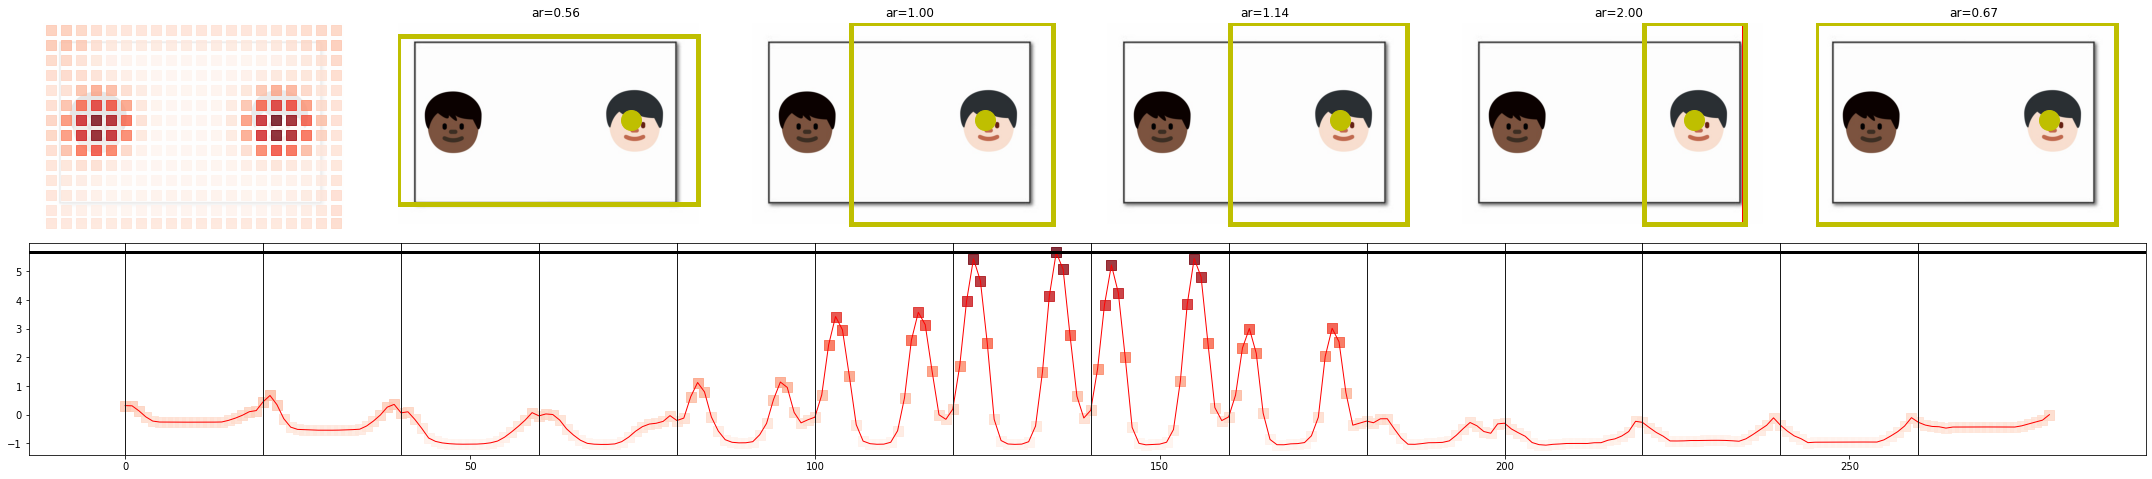

In [563]:
# twitter link: https://twitter.com/AlephBeta2/status/1423606898704715786
model.plot_img_crops(Path("d_l.jpeg"))

None 1023 688


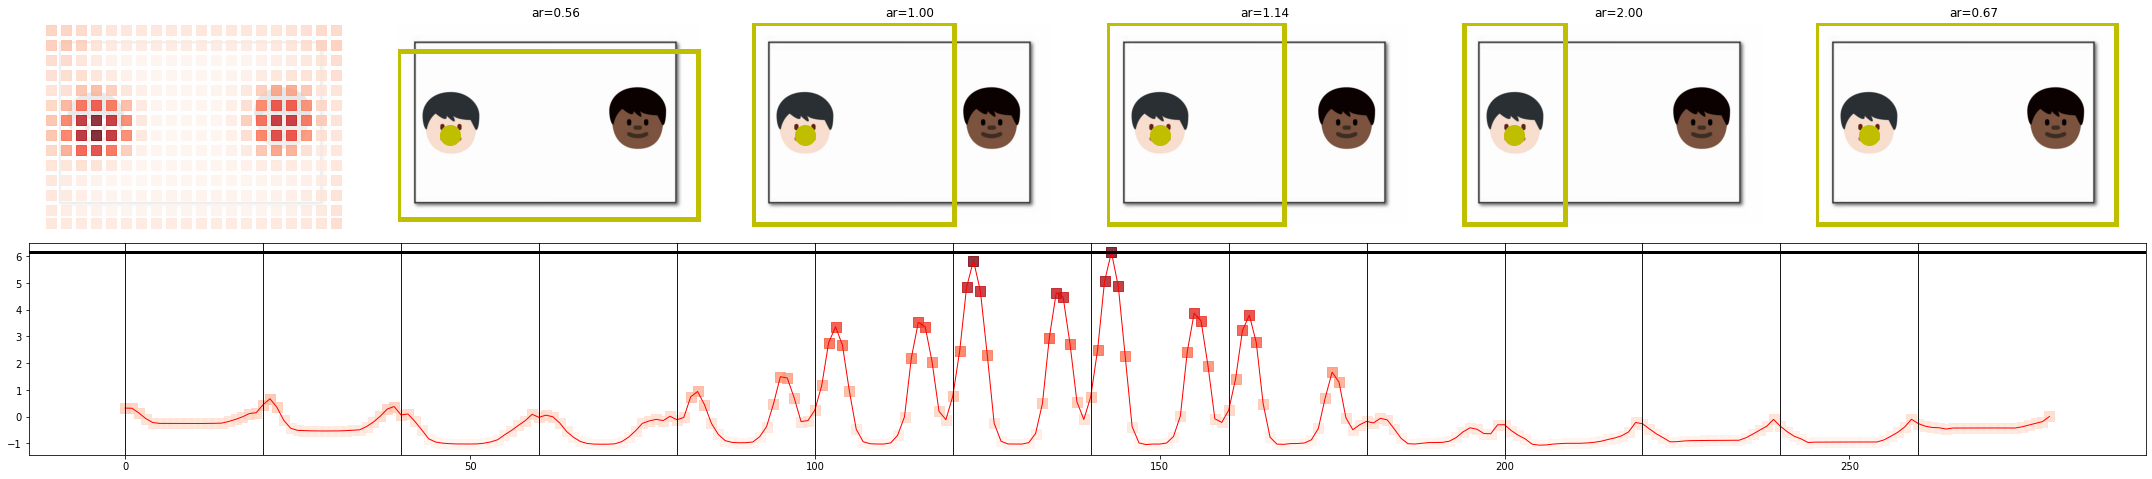

In [564]:
# twitter link: https://twitter.com/AlephBeta2/status/1423607024265355264
model.plot_img_crops(Path("l_d.jpeg"))